RES 335
RES 203
RES 122
RES 69
RES 37
RES 20
RES 11
RES 6
RES 4


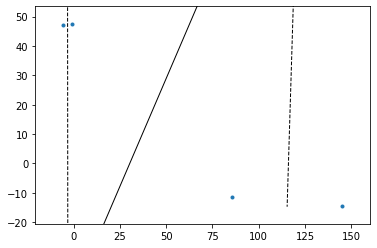

FINISHED
Found 2 clusters


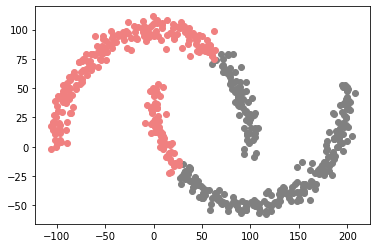

In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons

# from datasets import *

def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return round(dist, 7)  

def inCircle(x0, y0, r, x, y):
    if(math.pow(x-x0, 2) + math.pow(y-y0, 2) == math.pow(r, 2)):
        return True
    return False

def FlattenPrototype(prototype):
    assert len(prototype.keys()) == 1
    
    key = list(prototype.keys())[0]
    
    if prototype[key] == []:
        return [key]
    
    return_list = []

    for p in prototype[key]:
        return_list += FlattenPrototype(p)    
    
    return return_list

def VoronoiClustering(points, radius_threshold, min_samples):
    vor = Voronoi(points)

    """
    voronoi_plot_2d(vor)
    plt.ylim(0, 15)
    plt.xlim(0, 15)
    plt.show()
    """

    m = radius_threshold
    S = set(points)

    res_dict = {}
    for p in points:
        res_dict[p] = []

    while True:
        tempV = []
        tempR = []

        for x in vor.vertices:
            minimum = -1
            for y in S:
                temp = calculateDistance(x[0], x[1], y[0], y[1])
                if minimum == -1 or temp < minimum:
                    minimum = temp

            tempV.append(tuple(x))
            tempR.append(minimum)

        """
        print 
        print "VerticesSorted"
        """

        V = [x for _, x in sorted(zip(tempR,tempV), key=lambda pair: pair[0])]

        """
        print V
        print 
        print "RadiusSorted"
        """

        R = sorted(tempR)
        """
        print R
        
        voronoi_plot_2d(vor)

        x = plt.gca()
        for i in range(len(R)):
            circle = plt.Circle((V[i][0], V[i][1]), R[i], color='r', fill=False)
            x.add_artist(circle)

        plt.ylim(-100, 100)
        plt.xlim(-100, 100)
        plt.show()
        """

        new_res = {}
        S2 = set()
        prototype = set()

        #print('N', len(S), 'V', len(vor.vertices))
        for i in range(len(R)): #2n-5, where n is the number of points
            r = R[i]
            if r < m:
                found = 0

                for j in S:
                    if (calculateDistance(V[i][0], V[i][1], j[0], j[1]) == R[i]):
                        found += 1
                        if j not in prototype:
                            if V[i] not in S2:
                                S2.add(V[i])

                            prototype.add(j)

                            if V[i] not in new_res.keys():
                                new_res[V[i]] = [{j: res_dict[j]}]
                            else:
                                new_res[V[i]].append({j: res_dict[j]})
                
                assert found >= 3
            elif r > m:
                for j in S:
                    if j not in prototype:
                        new_res[j] = res_dict[j]
                        prototype.add(j)
                        S2.add(j)
                break


        if S == S2:
            voronoi_plot_2d(vor)
            plt.show()
            break
        else:        
            if len(S2) == 1:
                return [0] * len(points)

            if len(S2) == 2:
                S2 = list(S2)
                if calculateDistance(S2[0][0], S2[0][1], S2[1][0], S2[1][1]) < 2*m:
                    return [0] * len(points)

                break
                
            res_dict = new_res
            vor = Voronoi(list(S2))

            print("RES", len(S2))
            S = S2
    
    result = []
    prototypes_repr = list(res_dict.keys())

    merged_prototypes = res_dict

    while 1:
        new_merged_prototypes = {}

        points_to_merge = list(merged_prototypes.keys())

        min_pair_distance = -1
        min_pair_p_1 = None
        min_pair_p_2 = None

        for i in range(len(points_to_merge) - 1):
            for j in range(i+1, len(points_to_merge)):
                curr_dist = calculateDistance(points_to_merge[i][0], points_to_merge[i][1]\
                                    ,points_to_merge[j][0], points_to_merge[j][1])
                
                if (min_pair_distance == -1) or (curr_dist < min_pair_distance):
                    min_pair_distance = curr_dist
                    min_pair_p_1 = points_to_merge[i]
                    min_pair_p_2 = points_to_merge[j]
        
        if min_pair_distance <= m:
            mid_point = (((min_pair_p_1[0] + min_pair_p_2[0]) / 2), ((min_pair_p_1[1] + min_pair_p_2[1]) / 2))

            if mid_point not in merged_prototypes.keys():
                new_merged_prototypes[mid_point] = [{min_pair_p_1: merged_prototypes[min_pair_p_1]}, {min_pair_p_2: merged_prototypes[min_pair_p_2]}]
            else:
                new_merged_prototypes[mid_point] = merged_prototypes[mid_point]
                new_merged_prototypes[mid_point].append({min_pair_p_1: merged_prototypes[min_pair_p_1]})
                new_merged_prototypes[mid_point].append({min_pair_p_2: merged_prototypes[min_pair_p_2]})
            
            assert min_pair_p_1 in points_to_merge
            assert min_pair_p_2 in points_to_merge

            points_to_merge.remove(min_pair_p_1)
            points_to_merge.remove(min_pair_p_2)
        else:
            break

        for p in points_to_merge:
            new_merged_prototypes[p] = merged_prototypes[p]
        
        merged_prototypes = new_merged_prototypes
    
    res_dict = merged_prototypes

    prototypes_repr = list(res_dict.keys())

    print("FINISHED")  
    total_clusters = [[]]
    for i in range(len(prototypes_repr)):
        curr_cluster = FlattenPrototype({prototypes_repr[i]: res_dict[prototypes_repr[i]]})

        if len(curr_cluster) < min_samples:
            total_clusters[0] += curr_cluster
        else:
            total_clusters += [curr_cluster]
   
    result = []
    for p in points:
        for i in range(len(total_clusters)):
            if p in total_clusters[i]:
                result.append(i)
                break
    
    return result

def plot_cluster_results(data, labels, title=""):
    dif_labels = set(labels)
    print('Found', len(dif_labels), 'clusters')
    colors = ['black','grey', 'lightcoral', 'firebrick', 'red', 'orangered',
    'chocolate', 'orange', 'darkgoldenrod', 'yellow', 'darkolivegreen', 'lawngreen',
    'turquoise','teal', 'navy', 'indigo', 'magenta']

    for label in dif_labels:
        points_x = [p[0] for p, l in zip(data, labels) if l == label]
        points_y = [p[1] for p, l in zip(data, labels) if l == label]

        plt.scatter(points_x, points_y, c=colors[label])
    
    plt.title(title)
    plt.show()

points =  make_moons(550, noise=.05)
points = list(points[0])
points = [tuple([p[0]*100,p[1]*100]) for p in points]

plot_cluster_results(points, VoronoiClustering(points, 62, 6))

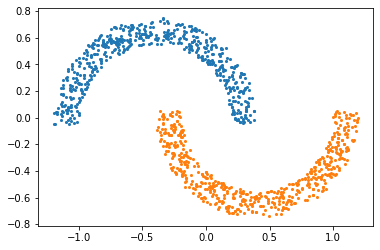

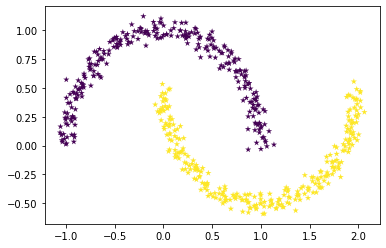

In [2]:


n_data_points = 550

rad = 0.6
thk = 0.2
sep = 0.1

c1 = np.array([(rad+thk)/2, sep/2])
c2 =  np.array([-(rad+thk)/2, -sep/2])

# We use random radius in the interval [rad, rad+thk]
#  and random angles from 0 to pi radians.
r1 = np.random.rand(n_data_points)*thk+rad
a1 = np.random.rand(n_data_points)*np.pi

r2 = np.random.rand(n_data_points)*thk+rad
a2 = np.random.rand(n_data_points)*np.pi+np.pi

# In order to plot it we convert it to cartesian:
p1 = np.array((r1*np.cos(a1), r1*np.sin(a1)))
p2 = np.array((r2*np.cos(a2), r2*np.sin(a2)))

x1, y1 = (p1[0] - c1[0], p1[1] - c1[1])
x2, y2 = (p2[0] - c2[0], p2[1] - c2[1])

import matplotlib.pyplot as plt
plt.scatter(x1, y1, marker='.', linewidths=0.1)
plt.scatter(x2, y2, marker='.', linewidths=0.1)
plt.show()

from sklearn.datasets import make_moons
X, y = make_moons(550, noise=.05, random_state=0)
plt.scatter(X[:,0], X[:,1], marker='*', linewidths=0.1, c=y)
plt.show()
